## Credit Default Prediction Modelling. 

### Introduction
- In this notebook, we explore a classification problem using XGBoost for a model to predict credit card defaulting based on some data on the user. 
- We'll use BQ opensource data source for the model. 

#### Data Import and EDA

In [2]:
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

from data_pipeline import load_credit_data

warnings.filterwarnings("ignore")

sns.set_style(
    "darkgrid",
)

df = load_credit_data()

df.head()

2025-06-11 18:58:35,585 - INFO - Attempting to load data from BigQuery...
2025-06-11 18:58:42,071 - INFO - Data successfully loaded from BigQuery and saved to CSV.


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,predicted_default_payment_next_month
id,,,,,,,,,,,,,,,,,,,,,
27502.0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0,...,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1,"[{'tables': {'score': 0.8667634129524231, 'val..."
26879.0,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0,...,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0,"[{'tables': {'score': 0.9351968765258789, 'val..."
18340.0,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0,...,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1,"[{'tables': {'score': 0.8572560548782349, 'val..."
13692.0,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0,...,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0,"[{'tables': {'score': 0.9690881371498108, 'val..."
20405.0,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0,...,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0,"[{'tables': {'score': 0.9349926710128784, 'val..."


In [3]:
df.describe()

,limit_balance,age,pay_0,pay_2,pay_3,pay_4,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,35.193255,0.005059,-0.122428,-0.141653,-0.185160,52118.305228,50649.153120,48239.757504,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518
std,125030.415472,9.109439,1.114395,1.180784,1.183630,1.178322,72328.670541,70785.001588,68145.710745,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,3958.000000,3390.000000,3302.000000,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,24257.000000,23111.000000,21520.000000,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000
75%,230000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,69852.000000,67827.000000,63023.000000,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000
max,800000.000000,69.000000,8.000000,7.000000,7.000000,8.000000,613860.000000,512650.000000,578971.000000,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000


In [4]:
df.info()

# na values,
# scalling

<class 'pandas.core.frame.DataFrame'>
Index: 2965 entries, 27502.0 to 28122.0
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   limit_balance                         2965 non-null   float64
 1   sex                                   2965 non-null   object 
 2   education_level                       2965 non-null   object 
 3   marital_status                        2965 non-null   object 
 4   age                                   2965 non-null   float64
 5   pay_0                                 2965 non-null   float64
 6   pay_2                                 2965 non-null   float64
 7   pay_3                                 2965 non-null   float64
 8   pay_4                                 2965 non-null   float64
 9   pay_5                                 2965 non-null   object 
 10  pay_6                                 2965 non-null   object 
 11  bill_amt_1   

In [5]:
# converting to correct data types
df[["pay_5", "pay_6"]] = df[["pay_5", "pay_6"]].astype("float64")

df[["sex", "education_level", "marital_status"]] = df[
    ["sex", "education_level", "marital_status"]
].astype("str")

In [6]:
df.sex.replace({"1": "Male", "2": "Female"}, inplace=True)

df.education_level.replace(
    {
        "0": "unknown",
        "1": "graduate school",
        "2": "university",
        "3": "high school",
        "4": "others",
        "5": "unknown",
        "6": "unknown",
    },
    inplace=True,
)

df.marital_status.replace(
    {"1": "married", "2": "single", "3": "Others", "0": "unknown"}, inplace=True
)

#### EDA Entire Dataset

<Axes: title={'center': 'Default Payment Next Month'}, xlabel='default_payment_next_month'>

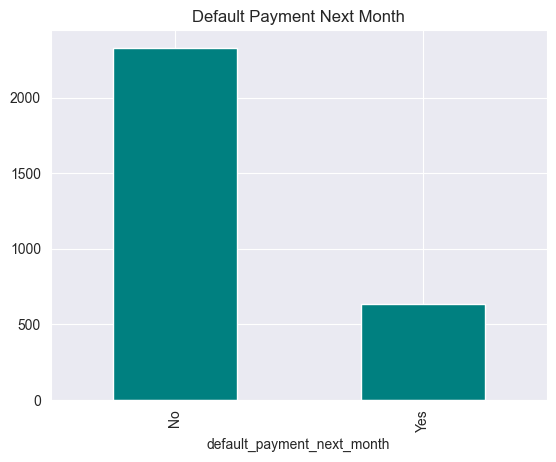

In [7]:
default_str = df["default_payment_next_month"].replace({"0": "No", "1": "Yes"})

default_str.value_counts().plot(
    kind="bar", title="Default Payment Next Month", color="teal"
)

Text(0.5, 1.0, 'Distribution of Limit Balance')

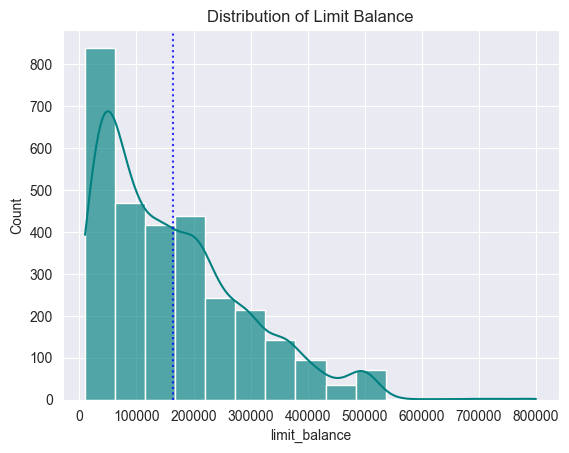

In [8]:
# limit balance distribution

sns.histplot(
    df,
    x="limit_balance",
    kde=True,
    bins=15,
    color="teal",
    multiple="stack",
    alpha=0.65,
)

plt.axvline(
    df.limit_balance.mean(),
    color="blue",
    linestyle=":",
    label="mean limit balance",
    alpha=0.8,
)

plt.title("Distribution of Limit Balance")

# TODO Add chart titles

# the limit balance data is positive skewed.
# so we should will use log transformation**
# but then xgboost is a treebased model, and will still handle skewed data well.

Text(0.5, 1.0, 'Distribution of Age')

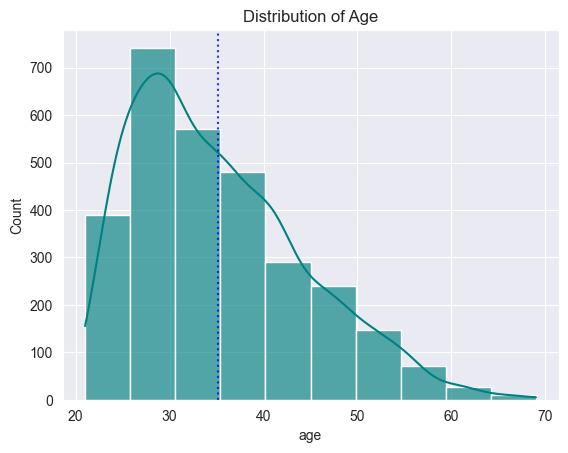

In [9]:
# age distribution

sns.histplot(
    df,
    x="age",
    kde=True,
    bins=10,
    color="teal",
    alpha=0.65,
    # hue="default_payment_next_month",
    multiple="stack",
)

plt.axvline(
    df.age.mean(),
    color="blue",
    linestyle=":",
    label="mean age",
    alpha=0.8,
)

plt.title("Distribution of Age")

<Axes: title={'center': 'Gender Distribution'}, ylabel='count'>

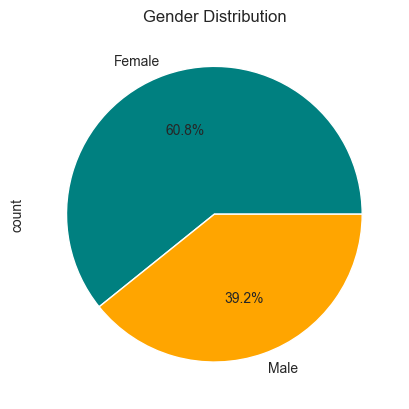

In [10]:
df.sex.value_counts().plot(
    kind="pie",
    title="Gender Distribution",
    autopct="%1.1f%%",
    colors=["teal", "orange"],
)

<Axes: title={'center': 'Marital Status Distribution'}, xlabel='marital_status'>

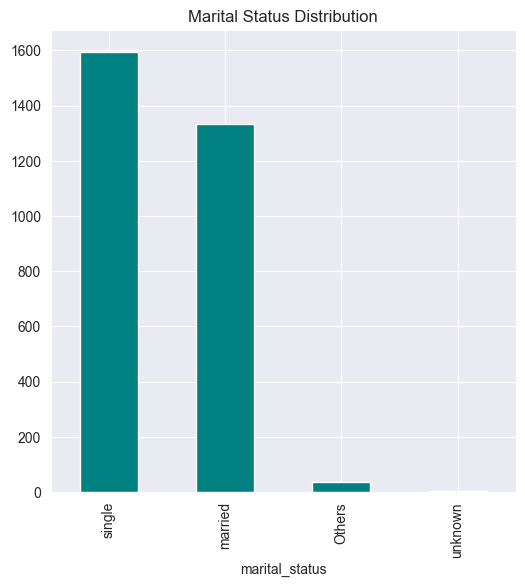

In [11]:
df.marital_status.value_counts().plot(
    kind="bar", figsize=(6, 6), color="teal", title="Marital Status Distribution"
)

Text(0.5, 1.0, 'Education Level Distribution')

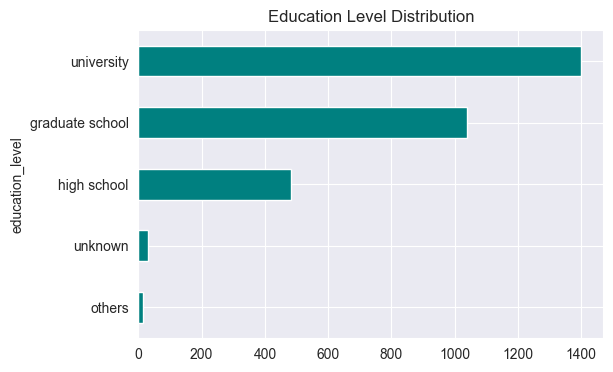

In [12]:
# edication level distribution:

df.education_level.value_counts().sort_values().plot(
    kind="barh", figsize=(6, 4), color="teal"
)

plt.title("Education Level Distribution")

Text(0.5, 1.0, 'Limit Balance by Education Level')

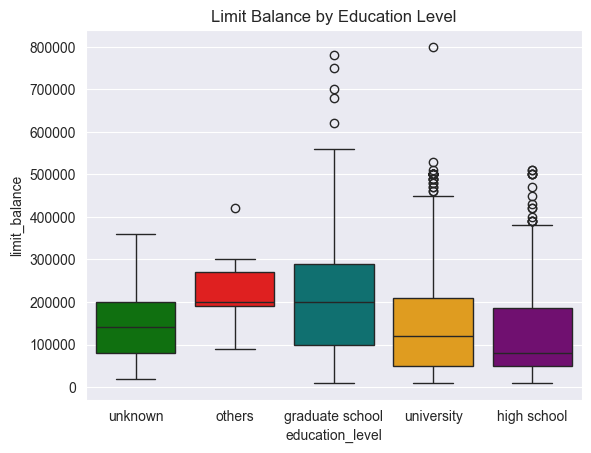

In [13]:
# a look at liimit balance by education level

sns.boxplot(
    x="education_level",
    y="limit_balance",
    data=df,
    palette=["green", "red", "teal", "orange", "purple", "brown"],
)

plt.title("Limit Balance by Education Level")

Text(0.5, 1.0, 'Limit Balance by Marital Status')

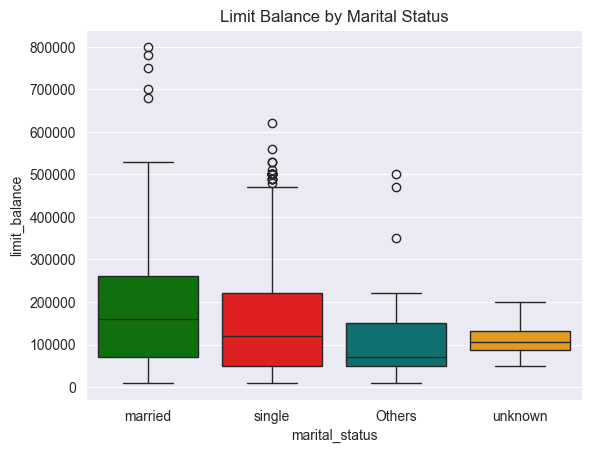

In [ ]:
# limit balance by marital status

sns.boxplot(
    x="marital_status",
    y="limit_balance",
    data=df,
    palette=["green", "red", "teal", "orange", "purple", "brown"],
)

plt.title("Limit Balance by Marital Status")

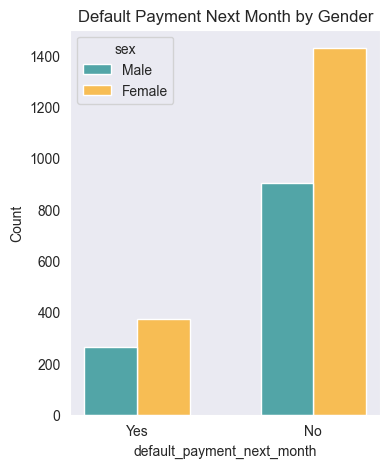

In [15]:
plt.figure(figsize=(4, 5))

sns.histplot(
    data=df,
    x=default_str,
    hue="sex",
    multiple="dodge",
    palette=["teal", "orange"],
    alpha=0.65,
    shrink=0.6,
)

plt.title("Default Payment Next Month by Gender")

plt.grid(False)

Text(0.5, 1.0, 'Default Payment Next Month by Marital Status')

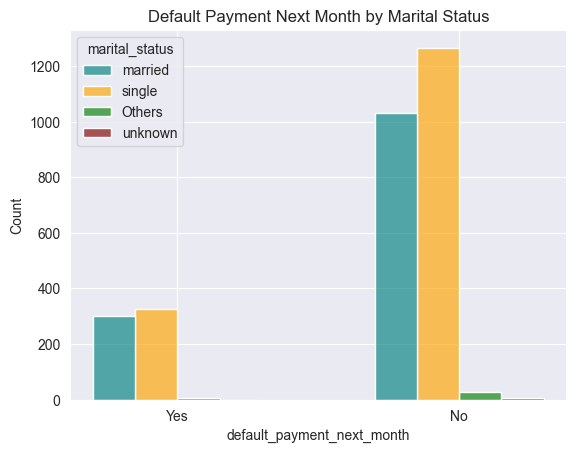

In [16]:
sns.histplot(
    data=df,
    x=default_str,
    hue="marital_status",
    multiple="dodge",
    palette=["teal", "orange", "green", "maroon"],
    alpha=0.65,
    shrink=0.6,
)

plt.title("Default Payment Next Month by Marital Status")

<Axes: xlabel='default_payment_next_month', ylabel='Count'>

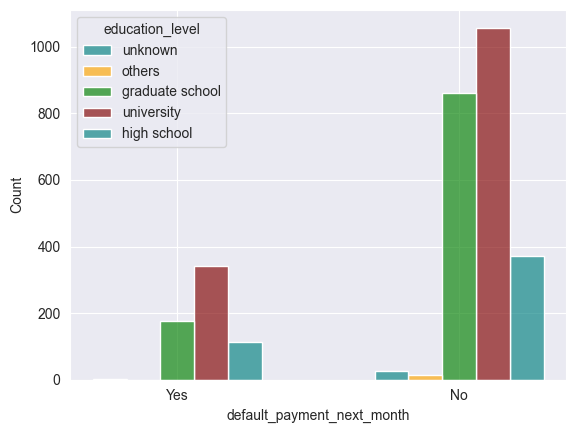

In [17]:
sns.histplot(
    data=df,
    x=default_str,
    hue="education_level",
    multiple="dodge",
    palette=["teal", "orange", "green", "maroon"],
    alpha=0.65,
    shrink=0.6,
)

#### Defaulters EDA

In [18]:
defaulters_df = df[df.default_payment_next_month == "1"]

Text(0.5, 1.0, 'Defaulters Age Distribution')

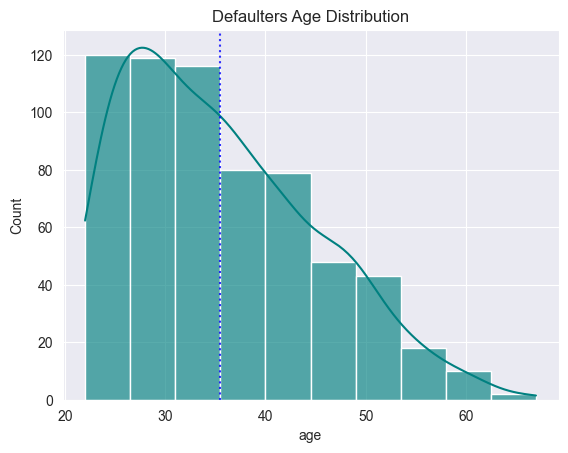

In [19]:
# defaulters age distribution

sns.histplot(
    data=defaulters_df,
    x="age",
    kde=True,
    bins=10,
    color="teal",
    alpha=0.65,
)

plt.axvline(
    defaulters_df.age.mean(),
    color="blue",
    linestyle=":",
    label="mean age",
    alpha=0.8,
)

plt.title("Defaulters Age Distribution")

<Axes: title={'center': 'Defaulters Education Level Distribution'}, ylabel='education_level'>

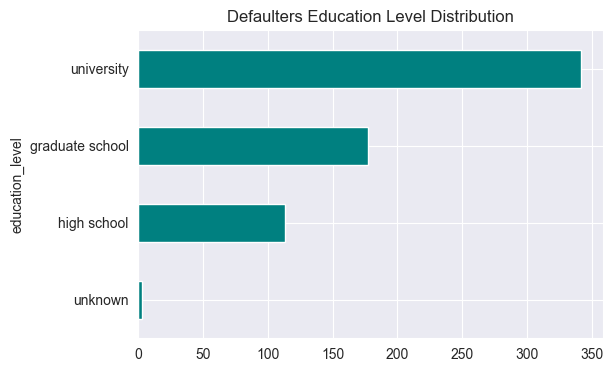

In [20]:
# defaulters education level distribution

defaulters_df.education_level.value_counts().sort_values().plot(
    kind="barh",
    figsize=(6, 4),
    color="teal",
    title="Defaulters Education Level Distribution",
)

Text(0.5, 1.0, 'Defaulters by Marital Status')

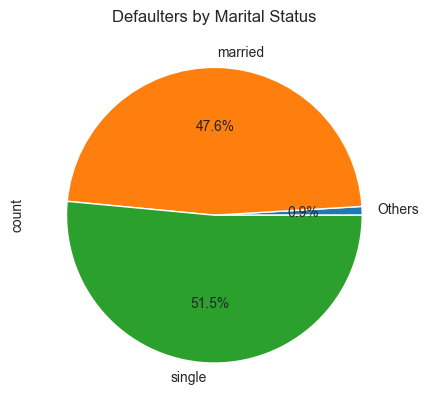

In [21]:
# defaulters_df.marital_status.value_counts().plot(kind='pie')

defaulters_df.marital_status.value_counts().sort_values().plot(
    kind="pie", autopct="%1.1f%%"
)

plt.title("Defaulters by Marital Status")

In [22]:
import plotly.express as px

<Axes: title={'center': 'Defaulters gender distribution'}, ylabel='count'>

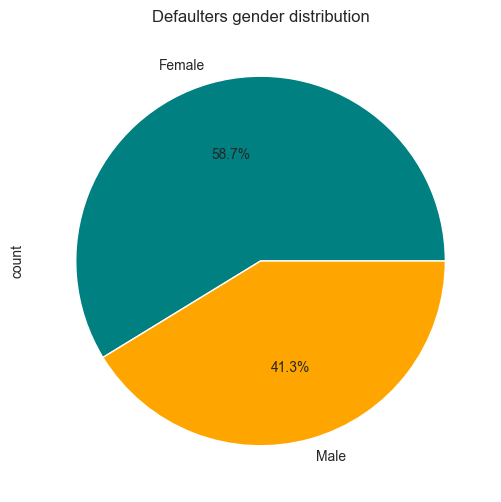

In [23]:
defaulters_df.sex.value_counts().plot(
    kind="pie",
    figsize=(6, 6),
    title="Defaulters gender distribution",
    colors=["teal", "orange"],
    autopct="%1.1f%%",
)

In [24]:
# checking for class imbalance in the target variable
# there is class imbalance in the target variable so we will try oversampling

df.default_payment_next_month.value_counts(normalize=True)

default_payment_next_month
0    0.785835
1    0.214165
Name: proportion, dtype: float64

In [25]:
# preparing data to encode categorical features.
# we'll use OneHotEncoder for this purpose since there are no ordinal features in the dataset.

df.drop(columns="predicted_default_payment_next_month").select_dtypes(
    include=["object"]
).nunique()

# defaulting by gender,
# defaulting by level
# defaulting by marital status

sex                           2
education_level               5
marital_status                4
default_payment_next_month    2
dtype: int64

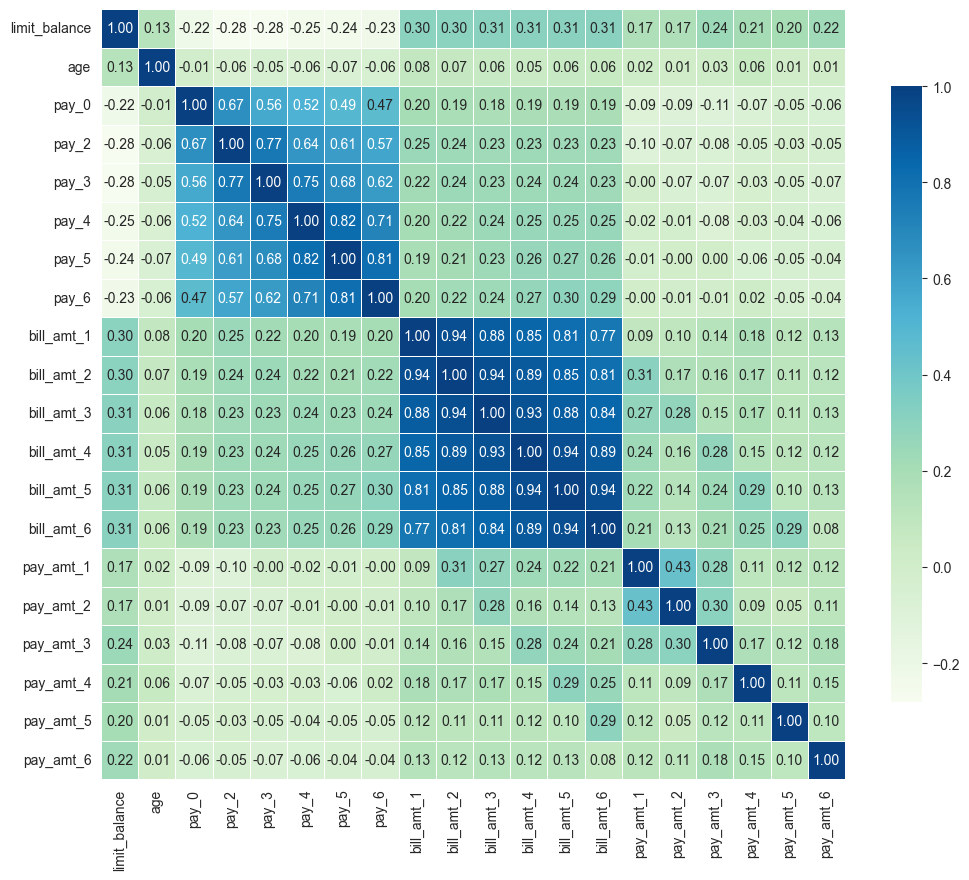

In [26]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    df.drop(columns="default_payment_next_month").corr(numeric_only=True),
    annot=True,
    cmap="GnBu",
    linewidths=0.7,
    linecolor="white",
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
)

plt.grid(False)
# there is a not much risk of multicollinearity in the dataset, as the correlation coefficients are generally <0.95.

#### Data Preprocessing

In [27]:
# Splitting the data into features and target variable

X = df.drop(
    columns=["default_payment_next_month", "predicted_default_payment_next_month"]
)

y = df.default_payment_next_month.astype("int")

In [28]:
# splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

### Model Traininng and Evaluation

#### (i) Using `xgboost` with `RandomOverSampler` to handle class imbalance

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

  No Default       0.88      0.86      0.87       473
     Default       0.49      0.53      0.51       120

    accuracy                           0.79       593
   macro avg       0.68      0.69      0.69       593
weighted avg       0.80      0.79      0.80       593



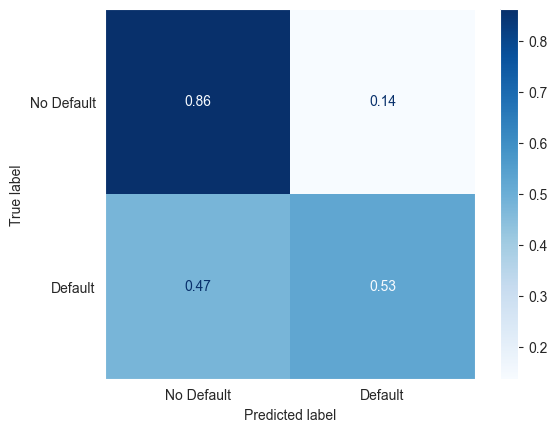

In [ ]:
over_sampler = RandomOverSampler(random_state=42)

# possible data leakage**
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

xgb_over = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    XGBClassifier(random_state=42, scale_pos_weight=1),
)

param_grid = {
    "xgbclassifier__n_estimators": [100, 300],
    "xgbclassifier__max_depth": [3, 6, 10],
    "xgbclassifier__learning_rate": [0.01, 0.1],
    "xgbclassifier__subsample": [0.8, 1.0],
    "xgbclassifier__colsample_bytree": [0.8, 1.0],
    "xgbclassifier__gamma": [0, 1],
    "xgbclassifier__reg_alpha": [0, 0.1],
    "xgbclassifier__reg_lambda": [1, 10],
}

xgb_over_model = RandomizedSearchCV(
    xgb_over, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)

xgb_over_model.fit(X_train_resampled, y_train_resampled)

with open("models/xgb_over_model.pkl", "wb") as f:
    pickle.dump(xgb_over_model, f)

print(
    classification_report(
        y_test,
        xgb_over_model.predict(X_test),
        target_names=["No Default", "Default"],
    )
)

ConfusionMatrixDisplay.from_estimator(
    xgb_over_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [32]:
# loading the saved model:

with open("models/xgb_over_model.pkl", "rb") as f:
    loaded_xgb_over_model = pickle.load(f)

loaded_xgb_over_model

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(handle_unknown='ignore',
                                                            sparse_output=False)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,...
                   n_jobs=-1,
                   param_distributions={'xgbclassifier__colsample_bytree': [0.8,
                                                                            1.0],
                                        'xgbclassifier__gamma': [0, 1],
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [3, 6, 10],
                                        'xgbclassifier__n_estimators': [100,
                                                                        300],
                                        'xgbclassifier__reg_alpha': [0, 0.1],
                                        'xgbclassifier__reg_lambda': [1, 10],
                                        'xgbclassifier__subsample': [0.8, 1.0]},
                   scoring='f1', verbose=1)

#### (ii) Using `xgboost` with `scale_pos_weight` to handle class imbalance

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

  No Default       0.90      0.64      0.75       473
     Default       0.33      0.71      0.45       120

    accuracy                           0.65       593
   macro avg       0.61      0.67      0.60       593
weighted avg       0.78      0.65      0.69       593



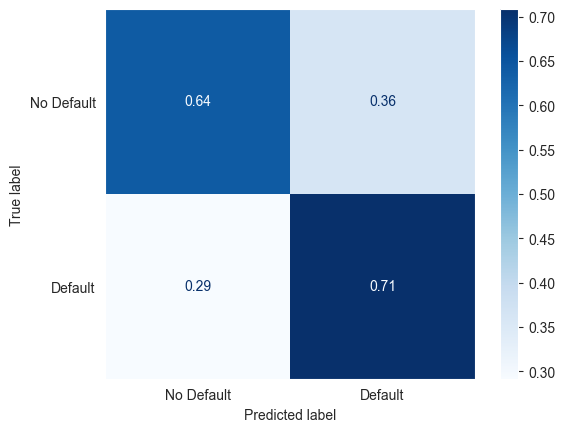

In [33]:
xgb_ = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    XGBClassifier(scale_pos_weight=78.58 / 21.42, random_state=42),
)

xgb_model = RandomizedSearchCV(
    xgb_, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)

xgb_model.fit(X_train_resampled, y_train_resampled)

with open("models/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_over_model, f)

print(
    classification_report(
        y_test,
        xgb_model.predict(X_test),
        target_names=["No Default", "Default"],
    )
)

ConfusionMatrixDisplay.from_estimator(
    xgb_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [187]:
with open("models/xgb_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

loaded_xgb_model

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(handle_unknown='ignore',
                                                            sparse_output=False)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,...
                   n_jobs=-1,
                   param_distributions={'xgbclassifier__colsample_bytree': [0.8,
                                                                            1.0],
                                        'xgbclassifier__gamma': [0, 1],
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [3, 6, 10],
                                        'xgbclassifier__n_estimators': [100,
                                                                        300],
                                        'xgbclassifier__reg_alpha': [0, 0.1],
                                        'xgbclassifier__reg_lambda': [1, 10],
                                        'xgbclassifier__subsample': [0.8, 1.0]},
                   scoring='f1', verbose=1)

#### (iii) Using CatBoostClassifier model

Fitting 3 folds for each of 20 candidates, totalling 60 fits
              precision    recall  f1-score   support

  No Default       0.87      0.82      0.84       466
     Default       0.45      0.54      0.49       127

    accuracy                           0.76       593
   macro avg       0.66      0.68      0.67       593
weighted avg       0.78      0.76      0.77       593



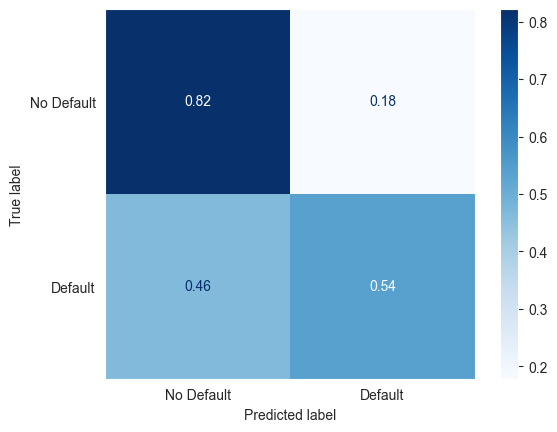

In [ ]:
catgb = CatBoostClassifier(verbose=0, random_state=42, scale_pos_weight=78.58 / 21.42)

catgb_params = {
    "iterations": [300, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [3, 5, 10, 25],
    "bagging_temperature": [0, 0.5, 1],
    "border_count": [32, 64, 128],
    "random_strength": [1, 5, 10],
    "rsm": [0.8, 0.9, 1.0],
}

catgb_model = RandomizedSearchCV(
    estimator=catgb,
    param_distributions=catgb_params,
    scoring="f1",
    cv=3,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

catgb_model.fit(X_train, y_train)

with open("models/catgb_model.pkl", "wb") as f:
    pickle.dump(catgb_model.best_estimator_, f)

y_pred = catgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["No Default", "Default"]))

ConfusionMatrixDisplay.from_estimator(
    catgb_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [195]:
with open("models/catgb_model.pkl", "rb") as f:
    loaded_catgb_model = pickle.load(f)

loaded_catgb_model

#### (iv) Using LGBMClassifier model

Fitting 3 folds for each of 20 candidates, totalling 60 fits
              precision    recall  f1-score   support

  No Default       0.85      0.86      0.86       466
     Default       0.48      0.46      0.47       127

    accuracy                           0.78       593
   macro avg       0.67      0.66      0.66       593
weighted avg       0.77      0.78      0.78       593



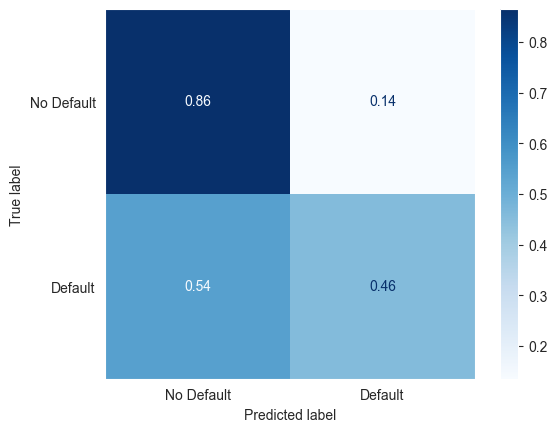

In [ ]:
lgb = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    LGBMClassifier(
        objective="binary",
        scale_pos_weight=78.58 / 21.42,
        random_state=42,
        verbosity=-1,
        n_jobs=-1,
    ),
)

lgb_params = {
    "lgbmclassifier__n_estimators": [300, 500, 1000],
    "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1],
    "lgbmclassifier__max_depth": [4, 6, 8, 10],
    "lgbmclassifier__num_leaves": [15, 31, 63],
    "lgbmclassifier__min_child_samples": [10, 20, 50],
    "lgbmclassifier__subsample": [0.7, 0.8, 1.0],
    "lgbmclassifier__colsample_bytree": [0.7, 0.8, 1.0],
    "lgbmclassifier__reg_alpha": [0, 0.1, 1],
    "lgbmclassifier__reg_lambda": [0, 0.1, 1],
}

lgb_model = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_params,
    scoring="f1",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

lgb_model.fit(X_train, y_train)

with open("models/lgb_model.pkl", "wb") as f:
    pickle.dump(lgb_model.best_estimator_, f)

y_pred = lgb_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["No Default", "Default"]))

ConfusionMatrixDisplay.from_estimator(
    lgb_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

#### (v) Stacking the best of xgboost, catboost, and lightgbm models, with logistic regression as the meta-learner

              precision    recall  f1-score   support

  No Default       0.85      0.93      0.89       466
     Default       0.60      0.39      0.47       127

    accuracy                           0.81       593
   macro avg       0.72      0.66      0.68       593
weighted avg       0.79      0.81      0.80       593



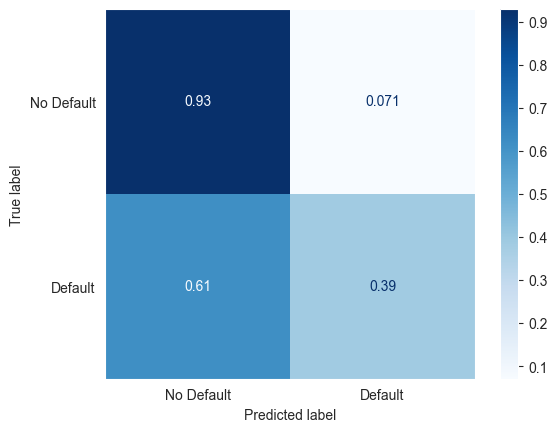

In [ ]:
with open("models/xgb_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

with open("models/lgb_model.pkl", "rb") as f:
    loaded_lgb_model = pickle.load(f)

with open("models/catgb_model.pkl", "rb") as f:
    loaded_catgb_model = pickle.load(f)


stack_classifier = StackingClassifier(
    estimators=[
        ("xgb", loaded_xgb_model.best_estimator_),
        ("catgb", loaded_catgb_model),
        ("lgb", loaded_lgb_model),
    ],
    final_estimator=LogisticRegression(),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
)

stack_classifier.fit(X_train, y_train)

with open("models/stack_classifier.pkl", "wb") as f:
    pickle.dump(stack_classifier, f)

print(
    classification_report(
        y_test,
        stack_classifier.predict(X_test),
        target_names=["No Default", "Default"],
    )
)

ConfusionMatrixDisplay.from_estimator(
    stack_classifier,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [5]:
with open("models/stack_classifier.pkl", "rb") as f:
    loaded_stack_classifier = pickle.load(f)

loaded_stack_classifier.feature_names_in_

array(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5',
       'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4',
       'pay_amt_5', 'pay_amt_6'], dtype=object)

In [ ]:
# TODO write a report based in this analysis abt 6-8 pages.

### Conclusion